## Accessing Chloris Biomass data with the Planetary Computer STAC API

The Chloris Global Biomass 2003–2019 dataset provides estimates of stock and change in aboveground biomass for Earth's terrestrial woody vegetation ecosystems. It covers the period 2003–2019, at annual time steps. The global dataset has an approximate 4.6 km spatial resolution.

This notebook provides an example of accessing Chloris Biomass data using the Planetary Computer STAC API, inspecting the data assets in the catalog, and doing some simple processing and plotting of the data from the Cloud Optimized GeoTIFF source.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [3]:
import matplotlib.pyplot as plt
import planetary_computer as pc
import rioxarray

from pystac_client import Client

### Query for available data

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
biomass = catalog.search(collections=["chloris-biomass"])

all_items = biomass.get_all_items()

print(f"Returned {len(all_items)} Items")

Returned 17 Items


Our search returned all 17 items in the collection. Each of the items represent a single year, between 2003 and 2019, at a global scale.

Let's see what assets are associated with this item:

In [5]:
# Grab the first item and print the titles of the assets it contains
item = all_items[0]
print(item.id + ":")
print(*[f"- {key}: {asset.title}" for key, asset in item.assets.items()], sep="\n")

chloris_biomass_50km_2019:
- biomass: Annual estimates of aboveground woody biomass.
- biomass_wm: Annual estimates of aboveground woody biomass (Web Mercator).
- biomass_change: Annual estimates of changes (gains and losses) in aboveground woody biomass from the previous year.
- biomass_change_wm: Annual estimates of changes (gains and losses) in aboveground woody biomass from the previous year (Web Mercator).
- tilejson: TileJSON with default rendering
- rendered_preview: Rendered preview


There are 4 assets, though two are duplicates of the same data, provided in Web Mercator projection. One represents the estimate for aboveground woody biomass for the given year (in tonnes), and the other represents the change (in tonnes) from the previous year.

Let's update our search to include just a specific year.

In [6]:
datetime = "2016-01-01"
biomass = catalog.search(collections=["chloris-biomass"], datetime=datetime)

# Sign the resulting item so we can access the underlying data assets
item = [pc.sign(item) for item in biomass.get_items()][0]
print(item)

<Item id=chloris_biomass_50km_2016>


#### Load the variable of interest

In [7]:
da = rioxarray.open_rasterio(item.assets["biomass"].href)

# Transform our data array to a dataset by selecting the only data variable ('band')
# renaming it to something useful ('biomass')
ds = da.to_dataset(dim="band").rename({1: "biomass"})
ds

<xarray.Dataset>
Dimensions:      (y: 3600, x: 8640)
Coordinates:
  * x            (x) float64 -2.001e+07 -2.001e+07 ... 2.001e+07 2.001e+07
  * y            (y) float64 1.001e+07 1e+07 9.996e+06 ... -6.665e+06 -6.669e+06
    spatial_ref  int64 0
Data variables:
    biomass      (y, x) uint32 ...
Attributes:
    _FillValue:    2147483647.0
    scale_factor:  1.0
    add_offset:    0.0

#### Downsample and render

For this global plot, it's ok to lose some detail in our rendering. First we'll downsample the entire dataset by a factor of 10 on each spatial dimension and drop any values above the nodata value.

In [8]:
%%time
factor = 10
coarse_biomass = (
    ds.biomass.coarsen(dim={"x": factor, "y": factor}, boundary="trim").mean().compute()
)

# Filter out nodata
coarse_biomass = coarse_biomass.where(coarse_biomass < ds.attrs["_FillValue"])
coarse_biomass.shape

CPU times: user 798 ms, sys: 293 ms, total: 1.09 s
Wall time: 6.58 s


(360, 864)

With our dataset nicely reduced, we can plot the above ground biomass for the planet in the original sinusoidal projection. 

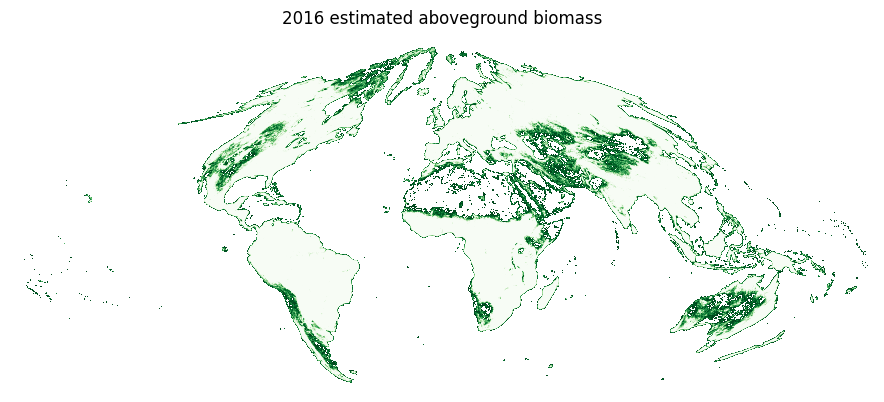

In [9]:
h, w = coarse_biomass.shape
dpi = 100
fig = plt.figure(frameon=False, figsize=(w / dpi, h / dpi), dpi=dpi)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)
coarse_biomass.plot(cmap="Greens", add_colorbar=False)

ax.set_title("2016 estimated aboveground biomass")
plt.show();